# 📖 Import Library 

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 💻 Load in data

In [4]:
df=pd.read_csv('../datasets/improved_poker_states.csv')

---

# 📊 Objective for Data Preparation

**My aims of this project are to:** </br>
- **Recommend Strategy:** Suggest optimal actions like Call, Fold, Raise based on in-game observations.

---

# 📌 Check the data 
- There are originally 13 columns with 34,005 rows
- There is 1 feature that having NaN
    - `community_cards`: Missing values might occur before any community cards are revealed (pre-flop).

In [9]:
df.shape

(34005, 13)

In [10]:
df.isnull().sum()

game_id                0
hand_id                0
round_index            0
player_name            0
action                 0
amount                 0
hole_cards             0
community_cards    22959
pot                    0
player_stack           0
small_blind            0
big_blind              0
winner                 0
dtype: int64

In [11]:
# See what columns do my dataset has...
df.head()

,game_id,hand_id,round_index,player_name,action,amount,hole_cards,community_cards,pot,player_stack,small_blind,big_blind,winner
0,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Dave,raise,30,S7-S5,NaN,60,970,10,20,Alice
1,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Alice,fold,0,C6-DK,NaN,60,1000,10,20,Alice
2,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Bob,raise,40,CA-DJ,NaN,90,960,10,20,Alice
3,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Carol,raise,62,D8-C2,NaN,132,938,10,20,Alice
4,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Dave,call,62,S7-S5,NaN,164,938,10,20,Alice


### 🔎 Investigate missing values 

### `community_cards`

In [14]:
# Count rows where round is 'preflop' and community_cards is NaN
df[(df['round_index'] == 'preflop') & (df['community_cards'].isna())].shape[0]

# This can confirm that missing values occur before any community cards are revealed (pre-flop).

22959

In [15]:
# Check  the percentage of each action each happen during preflop round 
# I want to make sure there are mixed of actions happen during preflop round
print(df[df['round_index'] == 'preflop'].groupby('player_name')['action'].value_counts(normalize=True).unstack(fill_value=0))

action           call      fold     raise
player_name                              
Alice        0.332753  0.332405  0.334842
Bob          0.328150  0.342478  0.329373
Carol        0.339021  0.331186  0.329793
Dave         0.331651  0.333391  0.334957


In [16]:
# The percentage of each action is balance. 
# I will replace missing value of `community_cards` to 0 as there will be 0 community cards during preflop round
df['community_cards'] = df['community_cards'].fillna(0)

---

### 👩🏼‍💻 Prepare data for futher analysis

In [19]:
# Split the hole_cards into individual cards
df[['card1', 'card2']] = df['hole_cards'].str.split('-', expand=True)

# Extract suit and rank for card1
df['card1_suit'] = df['card1'].str[0]
df['card1_rank'] = df['card1'].str[1:]

# Extract suit and rank for card2
df['card2_suit'] = df['card2'].str[0]
df['card2_rank'] = df['card2'].str[1:]

In [20]:
# Convert all entries to strings to handle non-string inputs
df["community_cards"] = df["community_cards"].astype(str)

max_cards = 5  # Number of columns to create (5 is the max number of community_cards)

# Extract ranks
ranks = df["community_cards"].apply(
    lambda x: [card[1:] for card in x.split("-") if card != "0" and card != ""] + [0] * (max_cards - len(x.split("-")))
              if x not in ["", "0"] else [0] * max_cards)

# Extract suits
suits = df["community_cards"].apply(
    lambda x: [card[0] for card in x.split("-") if card != "0" and card != ""] + [0] * (max_cards - len(x.split("-")))
              if x not in ["", "0"] else [0] * max_cards)

# Create new columns for each rank of `community_cards`
for i in range(max_cards):
    df[f"community{i+1}_rank"] = ranks.apply(lambda x: x[i] if i < len(x) else 0)
    df[f"community{i+1}_suit"] = suits.apply(lambda x: x[i] if i < len(x) else 0)

In [21]:
# Check work
df[['hole_cards','community_cards','card1_suit', 'card1_rank', 'card2_suit', 'card2_rank',
          'community1_rank', 'community1_suit', 'community2_rank', 'community2_suit',
          'community3_rank', 'community3_suit', 'community4_rank', 'community4_suit',
          'community5_rank', 'community5_suit']].head(10)

,hole_cards,community_cards,card1_suit,card1_rank,card2_suit,card2_rank,community1_rank,community1_suit,community2_rank,community2_suit,community3_rank,community3_suit,community4_rank,community4_suit,community5_rank,community5_suit
0,S7-S5,0,S,7,S,5,0,0,0,0,0,0,0,0,0,0
1,C6-DK,0,C,6,D,K,0,0,0,0,0,0,0,0,0,0
2,CA-DJ,0,C,A,D,J,0,0,0,0,0,0,0,0,0,0
3,D8-C2,0,D,8,C,2,0,0,0,0,0,0,0,0,0,0
4,S7-S5,0,S,7,S,5,0,0,0,0,0,0,0,0,0,0
5,CA-DJ,0,C,A,D,J,0,0,0,0,0,0,0,0,0,0
6,CA-DJ,H7-S8-S4,C,A,D,J,7,H,8,S,4,S,0,0,0,0
7,D8-C2,H7-S8-S4,D,8,C,2,7,H,8,S,4,S,0,0,0,0
8,S7-S5,H7-S8-S4,S,7,S,5,7,H,8,S,4,S,0,0,0,0
9,CA-DJ,H7-S8-S4,C,A,D,J,7,H,8,S,4,S,0,0,0,0


In [22]:
# I see in card suit store in str and some card rank is represent in alphabet 
# (e.g. T in this case is represent 10, K = King)

# I want to change to numerical for further analysis and train in model

In [23]:
# Define mapping dictionary for suits
suit_map = {'S': 4, 'H': 3, 'D': 2, 'C': 1}
# (1=Clubs, 2=Diamonds, 3=Hearts, 4=Spades)

# Fill missing values with 0 and map suits
df['card1_suit'] = df['card1_suit'].map(suit_map).fillna(0).astype(int)
df['card2_suit'] = df['card2_suit'].map(suit_map).fillna(0).astype(int)
df['community1_suit'] = df['community1_suit'].map(suit_map).fillna(0).astype(int)
df['community2_suit'] = df['community2_suit'].map(suit_map).fillna(0).astype(int)
df['community3_suit'] = df['community3_suit'].map(suit_map).fillna(0).astype(int)
df['community4_suit'] = df['community4_suit'].map(suit_map).fillna(0).astype(int)
df['community5_suit'] = df['community5_suit'].map(suit_map).fillna(0).astype(int)

In [24]:
# Define mapping dictionaries for ranks
rank_map = {'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}

# Map ranks to numbers, filling NaN with 0 where necessary and converting the result to int
df['card1_rank'] = df['card1_rank'].apply(lambda x: rank_map.get(x, x) if pd.notnull(x) else 0).astype(int)
df['card2_rank'] = df['card2_rank'].apply(lambda x: rank_map.get(x, x) if pd.notnull(x) else 0).astype(int)
df['community1_rank'] = df['community1_rank'].apply(lambda x: rank_map.get(x, x) if pd.notnull(x) else 0).astype(int)
df['community2_rank'] = df['community2_rank'].apply(lambda x: rank_map.get(x, x) if pd.notnull(x) else 0).astype(int)
df['community3_rank'] = df['community3_rank'].apply(lambda x: rank_map.get(x, x) if pd.notnull(x) else 0).astype(int)
df['community4_rank'] = df['community4_rank'].apply(lambda x: rank_map.get(x, x) if pd.notnull(x) else 0).astype(int)
df['community5_rank'] = df['community5_rank'].apply(lambda x: rank_map.get(x, x) if pd.notnull(x) else 0).astype(int)

In [25]:
# Check work
df[['hole_cards','community_cards','card1_suit', 'card1_rank', 'card2_suit', 'card2_rank',
          'community1_rank', 'community1_suit', 'community2_rank', 'community2_suit',
          'community3_rank', 'community3_suit', 'community4_rank', 'community4_suit',
          'community5_rank', 'community5_suit']].head(5)

,hole_cards,community_cards,card1_suit,card1_rank,card2_suit,card2_rank,community1_rank,community1_suit,community2_rank,community2_suit,community3_rank,community3_suit,community4_rank,community4_suit,community5_rank,community5_suit
0,S7-S5,0,4,7,4,5,0,0,0,0,0,0,0,0,0,0
1,C6-DK,0,1,6,2,13,0,0,0,0,0,0,0,0,0,0
2,CA-DJ,0,1,14,2,11,0,0,0,0,0,0,0,0,0,0
3,D8-C2,0,2,8,1,2,0,0,0,0,0,0,0,0,0,0
4,S7-S5,0,4,7,4,5,0,0,0,0,0,0,0,0,0,0


### Now, Let's catagorize the poker hand rank

**<div align="center">
  Poker hand rank descriptionm ♤ ♡ ♧ ♢**
</div>

| Rank | Poker Hand       | Description                                                       |
|------|------------------|-------------------------------------------------------------------|
| 1    | Nothing in hand   | Not a recognized poker hand                                      |
| 2    | One pair          | One pair of equal ranks within five cards                        |
| 3    | Two pairs         | Two pairs of equal ranks within five cards                       |
| 4    | Three of a kind   | Three equal ranks within five cards                              |
| 5    | Straight          | Five cards, sequentially ranked with no gaps                     |
| 6    | Flush             | Five cards with the same suit                                    |
| 7    | Full house        | Pair + different rank three of a kind                            |
| 8    | Four of a kind    | Four equal ranks within five cards                               |
| 9    | Straight flush    | Straight + flush                                                 |
| 10   | Royal flush       | {Ace, King, Queen, Jack, Ten} + flush                            |} + flush} + flush

In [28]:
# Step 1: Combine all rank and suits cards
df['all_suits'] = df[['community1_suit', 'community2_suit', 'community3_suit', 
                      'community4_suit', 'community5_suit', 'card1_suit', 'card2_suit']].values.tolist()

df['all_ranks'] = df[['community1_rank', 'community2_rank', 'community3_rank', 
                      'community4_rank', 'community5_rank', 'card1_rank', 'card2_rank']].values.tolist()

In [29]:
# Step 2: Clean up ranks and suits by removing any zero values (invalid cards)
df['all_suits'] = df['all_suits'].apply(lambda suits: [suit for suit in suits if suit != ''])
df['all_ranks'] = df['all_ranks'].apply(lambda ranks: [rank for rank in ranks if rank != 0])

In [30]:
# Step 3: Count occurrences of suits and ranks, only considering non-zero values
df['suit_counts'] = df['all_suits'].apply(lambda suits: pd.Series(suits).value_counts().to_dict())
df['rank_counts'] = df['all_ranks'].apply(lambda ranks: pd.Series(ranks).value_counts().to_dict())

In [31]:
# Step 4: Initialize poker_hand column
df['poker_hand'] = 1 # No pair start with 1

# Step 5: Assign poker hand values
# Royal Flush: All cards same suit and ranks 14, 13, 12, 11, 10
royal_set = {14, 13, 12, 11, 10}
df.loc[
    (df['suit_counts'].apply(lambda x: len(x) == 1)) & 
    (df['all_ranks'].apply(lambda x: set(x) == royal_set)), 
    'poker_hand'] = 10

# Straight Flush: All cards same suit, and ranks form a consecutive sequence
df.loc[
    (df['suit_counts'].apply(lambda x: len(x) == 1)) & 
    (df['rank_counts'].apply(lambda x: len(x) == 5 and max(x.keys()) - min(x.keys()) == 4)), 
    'poker_hand'] = 9

# Four of a Kind: Four cards of the same rank
df.loc[
    df['rank_counts'].apply(lambda x: 4 in x.values()), 
    'poker_hand'] = 8

# Full House: Three of one rank and two of another
df.loc[
    df['rank_counts'].apply(lambda x: sorted(x.values()) == [2, 3]), 
    'poker_hand'] = 7

# Flush: All cards of the same suit
df.loc[
    df['suit_counts'].apply(lambda x: len(x) == 1), 
    'poker_hand'] = 6

# Straight: Cards form a consecutive sequence
df.loc[
    (df['rank_counts'].apply(lambda x: len(x) == 5)) & 
    (df['rank_counts'].apply(lambda x: max(x.keys()) - min(x.keys()) == 4)), 
    'poker_hand'] = 5

# Three of a Kind: Three cards of the same rank
df.loc[
    df['rank_counts'].apply(lambda x: 3 in x.values()), 
    'poker_hand'] = 4

# Two Pairs: Two pairs of the same rank
df.loc[
    df['rank_counts'].apply(lambda x: list(x.values()).count(2) == 2), 
    'poker_hand'] = 3

# One Pair: One pair of the same rank
df.loc[
    df['rank_counts'].apply(lambda x: 2 in x.values()), 
    'poker_hand'] = 2

In [32]:
# Step 6: Clean up intermediate columns (I don't need anymore)
df.drop(['all_suits', 'all_ranks', 'suit_counts', 'rank_counts'], axis=1, inplace=True)

In [33]:
# Check work (See the rank)
df[['hole_cards','community_cards','poker_hand']].head(10)

,hole_cards,community_cards,poker_hand
0,S7-S5,0,1
1,C6-DK,0,1
2,CA-DJ,0,1
3,D8-C2,0,1
4,S7-S5,0,1
5,CA-DJ,0,1
6,CA-DJ,H7-S8-S4,1
7,D8-C2,H7-S8-S4,2
8,S7-S5,H7-S8-S4,2
9,CA-DJ,H7-S8-S4,1


In [34]:
# Calculate the action relative to pof
# WHY: The amount a player bets compared to the pot size can provide valuable insights into their strategy. 
#       A large bet might indicate strength or bluffing, while a small bet may indicate weakness or a drawing hand.
df['bet_to_pot_ratio'] = df['amount'] / df['pot']
df[['amount','pot','bet_to_pot_ratio']].head(5)

,amount,pot,bet_to_pot_ratio
0,30,60,0.500000
1,0,60,0.000000
2,40,90,0.444444
3,62,132,0.469697
4,62,164,0.378049


In [35]:
# Calculate Plater Aggression
# WHY: See how likely they are to bluff. 
#      Players who bet and raise frequently are generally more aggressive, whereas passive players might fold more often.
df['aggression'] = df['amount'] / (df['player_stack'] + df['pot'])
df[['aggression','amount','pot']].head()

,aggression,amount,pot
0,0.029126,30,60
1,0.000000,0,60
2,0.038095,40,90
3,0.057944,62,132
4,0.056261,62,164


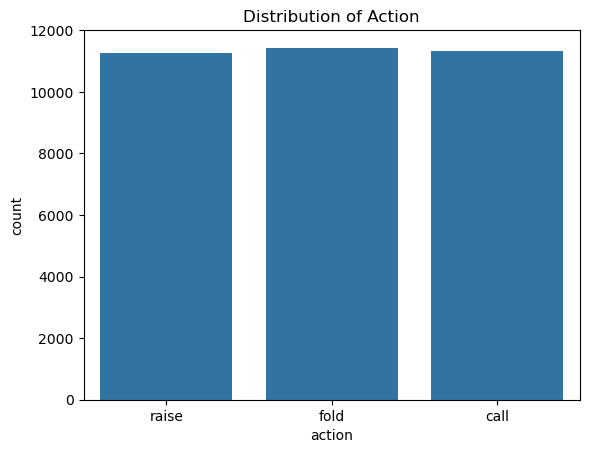

In [36]:
# Distribution of "Action"
sns.countplot(x="action", data=df)
plt.title('Distribution of Action')
plt.savefig('../images/Distribution_ofPlayerActions.png', format='png', dpi=300)
plt.show()

In [37]:
# Create a numerical feature action_label where call = 0, raise = 1, fold = 2
df['action_label'] = df['action'].map({'call': 0, 'raise': 1, 'fold': 2})

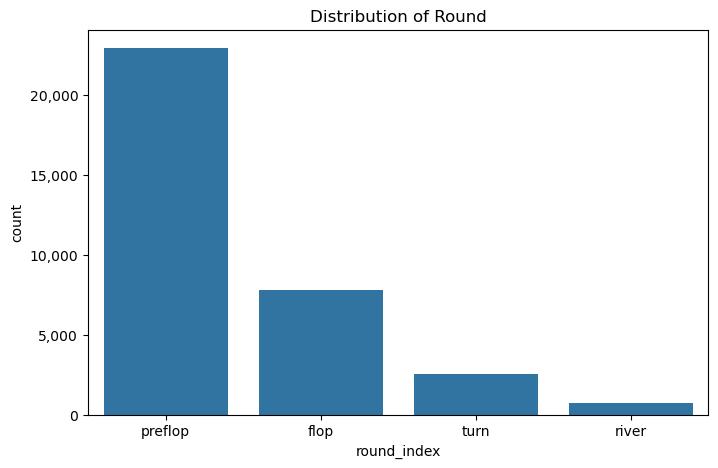

In [38]:
# Plotting the distribution of the 'round' column
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='round_index')
plt.title('Distribution of Round')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}')) # Add comma for readability
plt.savefig('../images/Distribution_ofRound.png', format='png', dpi=300)
plt.show()

In [39]:
# Create a numerical feature round_index where pre-flop = 1, flop = 2, turn = 3, river = 4
df['round_label'] = df['round_index'].map({'preflop': 1, 'flop': 2, 'turn': 3, 'river': 4})

In [40]:
# Change name of round_index to round for easier to understand
df.rename(columns={'round_index': 'round'}, inplace=True)

In [41]:
df.isnull().sum()

game_id             0
hand_id             0
round               0
player_name         0
action              0
amount              0
hole_cards          0
community_cards     0
pot                 0
player_stack        0
small_blind         0
big_blind           0
winner              0
card1               0
card2               0
card1_suit          0
card1_rank          0
card2_suit          0
card2_rank          0
community1_rank     0
community1_suit     0
community2_rank     0
community2_suit     0
community3_rank     0
community3_suit     0
community4_rank     0
community4_suit     0
community5_rank     0
community5_suit     0
poker_hand          0
bet_to_pot_ratio    0
aggression          0
action_label        0
round_label         0
dtype: int64

In [42]:
df.head() # Check overall data again

,game_id,hand_id,round,player_name,action,amount,hole_cards,community_cards,pot,player_stack,...,community3_suit,community4_rank,community4_suit,community5_rank,community5_suit,poker_hand,bet_to_pot_ratio,aggression,action_label,round_label
0,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Dave,raise,30,S7-S5,0,60,970,...,0,0,0,0,0,1,0.500000,0.029126,1,1
1,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Alice,fold,0,C6-DK,0,60,1000,...,0,0,0,0,0,1,0.000000,0.000000,2,1
2,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Bob,raise,40,CA-DJ,0,90,960,...,0,0,0,0,0,1,0.444444,0.038095,1,1
3,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Carol,raise,62,D8-C2,0,132,938,...,0,0,0,0,0,1,0.469697,0.057944,1,1
4,a0fff211-95be-4c79-9382-2aafbd635955,1,preflop,Dave,call,62,S7-S5,0,164,938,...,0,0,0,0,0,1,0.378049,0.056261,0,1


---

In [44]:
df.to_csv('../datasets/poker_completed.csv', index=False)